In [21]:
import xarray as xr
from sklearn import model_selection
import numpy as np
import pandas as pd

from yellowbrick.regressor import residuals_plot, prediction_error
from lightgbm import LGBMRegressor, plot_importance, plot_metric
from pvlib import clearsky, irradiance

In [2]:
site_data = xr.open_dataset('site_data.nc')
site_data

<xarray.Dataset>
Dimensions:                   (site: 12, time: 618578)
Coordinates:
  * time                      (time) datetime64[ns] 2018-03-01T07:00:00 ... 2019-06-02T06:59:00
  * site                      (site) object 'Albuquerque New Mexico' ... 'University of Oregon SRML'
Data variables:
    dhi                       (time, site) float32 ...
    dni                       (time, site) float32 ...
    ghi                       (time, site) float32 ...
    network                   (site) object ...
    latitude                  (site) float64 ...
    longitude                 (site) float64 ...
    elevation                 (site) float64 ...
    network_api_id            (site) object ...
    network_api_abbreviation  (site) object ...
    timezone                  (site) object ...
    attribution               (site) object ...

In [3]:
data = xr.open_dataset('one_year_mcmipc.nc').load()
for v in ('latitude', 'longitude', 'elevation'):
    data[v] = (('time', 'site'), 
               np.broadcast_to(site_data[v], (data.dims['time'], data.dims['site'])))
data

<xarray.Dataset>
Dimensions:     (shifted: 2, site: 12, time: 47793)
Coordinates:
  * site        (site) object 'Albuquerque New Mexico' ... 'University of Oregon SRML'
  * shifted     (shifted) int64 0 1
  * time        (time) datetime64[ns] 2018-03-01T13:03:41.361302016 ... 2019-02-28T23:58:32.052562048
Data variables:
    height      (time, site, shifted) float64 0.502 0.502 7.603 ... 3.45 3.45
    cloud_type  (time, site, shifted) float64 3.0 3.0 2.0 2.0 ... 3.0 2.0 2.0
    cloudy      (time, site, shifted) float64 0.0 0.0 1.0 1.0 ... 0.0 1.0 1.0
    CMI_C01     (time, site, shifted) float64 0.0 0.0 0.0 ... 0.286 0.286
    CMI_C02     (time, site, shifted) float64 0.0 0.0 0.0 ... 0.2581 0.2581
    CMI_C03     (time, site, shifted) float64 0.0 0.0 0.0 ... 0.2956 0.2956
    CMI_C04     (time, site, shifted) float64 0.0006349 0.0006349 ... 0.009841
    CMI_C05     (time, site, shifted) float64 0.0 0.0 0.0 ... 0.1886 0.1886
    CMI_C06     (time, site, shifted) float64 0.0 0.0 0.0 ... 0.1495 0.1495
    CMI_C07     (time, site, shifted) float64 262.7 262.7 256.0 ... 277.6 277.6
    CMI_C08     (time, site, shifted) float64 237.5 237.5 225.4 ... 230.6 230.6
    CMI_C09     (time, site, shifted) float64 246.6 246.6 230.6 ... 237.7 237.7
    CMI_C10     (time, site, shifted) float64 254.2 254.2 234.4 ... 242.2 242.2
    CMI_C11     (time, site, shifted) float64 262.4 262.4 246.2 ... 252.9 252.9
    CMI_C12     (time, site, shifted) float64 241.4 241.4 232.6 ... 228.1 228.1
    CMI_C13     (time, site, shifted) float64 263.7 263.7 247.2 ... 255.0 255.0
    CMI_C14     (time, site, shifted) float64 264.1 264.1 244.7 ... 255.1 255.1
    CMI_C15     (time, site, shifted) float64 264.4 264.4 242.9 ... 254.4 254.4
    CMI_C16     (time, site, shifted) float64 256.3 256.3 237.1 ... 244.5 244.5
    ghi         (time, site) float64 -4.7 -1.133 -0.06667 ... 255.8 297.0 95.55
    dni         (time, site) float64 1.533 0.0 0.8 0.4 ... 769.2 774.6 -0.0805
    dhi         (time, site) float64 0.3 0.0 0.0 0.0 ... 33.25 52.73 60.23 96.0
    zenith      (time, site) float64 97.37 105.0 97.08 ... 74.06 72.32 70.73
    azimuth     (time, site) float64 93.99 88.2 93.32 86.1 ... 249.7 245.9 237.5
    latitude    (time, site) float64 35.04 36.62 48.31 ... 32.23 36.11 44.05
    longitude   (time, site) float64 -106.6 -116.0 -105.1 ... -115.1 -123.1
    elevation   (time, site) float64 1.617e+03 1.007e+03 634.0 ... 615.0 133.8

In [28]:
data['extra_radiation'] = ('time', irradiance.get_extra_radiation(pd.DatetimeIndex(data.time.data)))

In [43]:
def get_data(sites, use_shift, data=data, test_size=0.25):
    vars_ = [v for v in data.variables.keys() if v.startswith('CMI_C') ] + [
         'zenith', 'azimuth', 'extra_radiation', 'elevation', 'latitude', 'longitude']
    if use_shift:
        vars_ += ['cloud_type', 'height', 'cloudy']
        shifted = 1
    else:
        shifted = 0
    X = data[vars_]
    ok_zenith = (data['zenith'] < 90)
    y = (data['ghi'] ).astype('float32').where(ok_zenith).sel(site=sites)
    X = X.where(ok_zenith).sel(site=sites).astype('float32')
    lenv = len(vars_) 
    train_ind, test_ind = next(model_selection.ShuffleSplit(n_splits=1, random_state=0, test_size=test_size).split(X.time.data)) 
    X_test = X.isel(time=test_ind, shifted=shifted).to_array().data.T.reshape((-1, lenv))
    y_test = y.isel(time=test_ind).data.T.reshape(-1)
    test_nans = np.isnan(X_test).any(axis=1) | np.isnan(y_test) | np.isinf(y_test)
    X_test = X_test[~test_nans]
    y_test = y_test[~test_nans]
    cloudy_test = data['cloudy'].sel(site=sites).isel(time=test_ind, shifted=shifted).data.reshape(-1)[~test_nans]
    
    X_train = X.isel(time=train_ind, shifted=shifted).to_array().data.T.reshape((-1, lenv))
    y_train = y.isel(time=train_ind).data.T.reshape(-1)
    train_nans = np.isnan(X_train).any(axis=1) | np.isnan(y_train) | np.isinf(y_train)
    X_train = X_train[~train_nans]
    y_train = y_train[~train_nans]
    cloudy_train = data['cloudy'].sel(site=sites).isel(time=train_ind, shifted=shifted).data.reshape(-1)[~train_nans]
    return X_train, y_train, cloudy_train, X_test, y_test, cloudy_test
    

In [44]:
X_train, y_train, cloudy_train, X_test, y_test, cloudy_test = get_data(data.site, 1, data)
X_train.shape

(363609, 25)

In [45]:
model = LGBMRegressor(boosting_type='dart', num_leaves=90, 
                    learning_rate=1e-1, n_estimators=500,
                    min_child_weight=1e-2,
                    min_child_samples=5, max_depth=-1,
                    reg_alpha=1e-1, reg_lambda=1e-1)

%time model.fit(X_train, y_train)

CPU times: user 7min 43s, sys: 582 ms, total: 7min 43s
Wall time: 1min 1s


LGBMRegressor(boosting_type='dart', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=5, min_child_weight=0.01, min_split_gain=0.0,
              n_estimators=500, n_jobs=-1, num_leaves=90, objective=None,
              random_state=None, reg_alpha=0.1, reg_lambda=0.1, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [46]:
%time model.score(X_train, y_train), model.score(X_test, y_test)

CPU times: user 22.8 s, sys: 22.6 ms, total: 22.8 s
Wall time: 3.03 s


(0.9284619170300767, 0.9124430944898239)

In [47]:
%time y_prd = model.predict(X_test)
rmse = np.sqrt(np.mean((y_prd - y_test)**2))
rmse

CPU times: user 5.99 s, sys: 8.77 ms, total: 6 s
Wall time: 878 ms


91.37737859488215

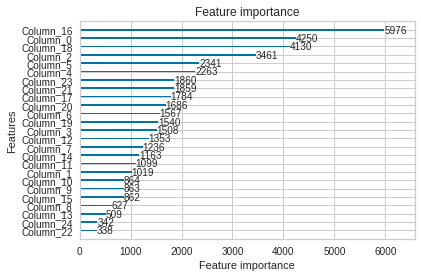

In [48]:
plot_importance(model)

/home/alorenzo/.pyenv/versions/miniconda3/envs/goesalg/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


PredictionError(alpha=0.01,
                ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fdeeeab4b00>,
                bestfit=True, identity=True, is_fitted='auto', model=None,
                shared_limits=True)

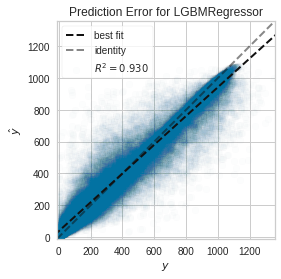

In [51]:
prediction_error(model, X_train, y_train, alpha=0.01)

/home/alorenzo/.pyenv/versions/miniconda3/envs/goesalg/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


PredictionError(alpha=0.01,
                ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fdeeea3fac8>,
                bestfit=True, identity=True, is_fitted='auto', model=None,
                shared_limits=True)

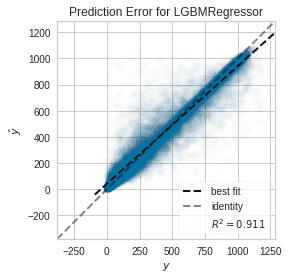

In [52]:
prediction_error(model, X_test, y_test, alpha=0.01)

/home/alorenzo/.pyenv/versions/miniconda3/envs/goesalg/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


PredictionError(alpha=0.05,
                ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fdeee6d00b8>,
                bestfit=True, identity=True, is_fitted='auto', model=None,
                shared_limits=True)

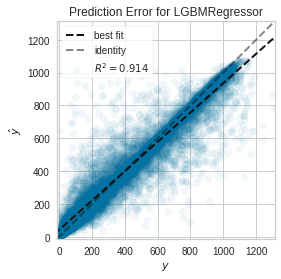

In [67]:
prediction_error(model, X_test[cloudy_test ==0], y_test[cloudy_test==0], alpha=0.05)

/home/alorenzo/.pyenv/versions/miniconda3/envs/goesalg/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


PredictionError(alpha=0.05,
                ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fdeee7c4e80>,
                bestfit=True, identity=True, is_fitted='auto', model=None,
                shared_limits=True)

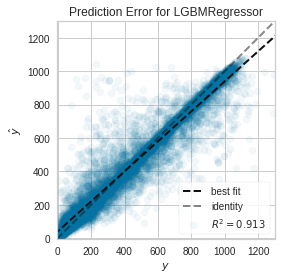

In [64]:
prediction_error(model, X_test[cloudy_test ==1], y_test[cloudy_test==1], alpha=0.05)

In [54]:
y_prd = model.predict(X_test)
rmse = np.sqrt(np.mean((y_prd - y_test)**2))
rmse

91.37737859488215

In [59]:
import pickle
with open('year_ghi.pkl', 'wb') as f:
    pickle.dump(model, f)

In [60]:
with open('ghi_sets.pkl', 'wb') as f:
    pickle.dump({'X_test': X_test, 'y_test': y_test, 'cloudy_test': cloudy_test,
                 'X_train': X_train, 'y_train': y_train, 'cloudy_train': cloudy_train}, f)

### Compare to only using satellite data (no derived height, cloud type) 

In [55]:
X_train_less, y_train_less, cloudy_train_less, X_test_less, y_test_less, cloudy_test_less = get_data(data.site.data, False, data)
X_train_less.shape

(363609, 22)

In [56]:
less_model = LGBMRegressor(boosting_type='dart', num_leaves=90, 
                    learning_rate=1e-1, n_estimators=500,
                    min_child_weight=1e-2,
                    min_child_samples=5, max_depth=-1,
                    reg_alpha=1e-1, reg_lambda=1e-1)

%time less_model.fit(X_train_less, y_train_less)

CPU times: user 7min 49s, sys: 701 ms, total: 7min 49s
Wall time: 1min 2s


LGBMRegressor(boosting_type='dart', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=5, min_child_weight=0.01, min_split_gain=0.0,
              n_estimators=500, n_jobs=-1, num_leaves=90, objective=None,
              random_state=None, reg_alpha=0.1, reg_lambda=0.1, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [57]:
%time less_model.score(X_train_less, y_train_less), less_model.score(X_test_less, y_test_less)

CPU times: user 22 s, sys: 21.5 ms, total: 22 s
Wall time: 3.09 s


(0.9280619740928624, 0.9118328820526862)

In [58]:
y_prd = less_model.predict(X_test_less)
rmse = np.sqrt(np.mean((y_prd - y_test_less)**2))
rmse

91.69524500381637

### Basically no difference yet between training with or without derived height

In [70]:
data.time.min(), data.time.max()

(<xarray.DataArray 'time' ()>
 array('2000-01-01T11:43:21.000000000', dtype='datetime64[ns]'),
 <xarray.DataArray 'time' ()>
 array('2019-02-28T23:58:32.052562048', dtype='datetime64[ns]'))